In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense 
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical 
import time
import warnings
from keras.layers import Dropout, Activation, Flatten, Convolution1D, Dropout
from keras.layers import BatchNormalization
import datetime as dt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn


In [59]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Fri Oct 18 11:44:11 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   62C    P5              6W /   60W |     119MiB /   4096MiB |     42%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
df = pd.read_csv('02-21-2018.csv', low_memory=True)
df2 = pd.read_csv('03-01-2018.csv', low_memory=True)
df3 = pd.read_csv('03-02-2018.csv', low_memory=True)

In [3]:
combined_df = pd.concat([df, df2, df3], axis=0)
combined_df = combined_df.rename(columns={'label': 'Label'})
combined_df = combined_df.sample(frac=0.5, random_state=42)
combined_df = combined_df[combined_df['Label'] != 'DDOS attack-LOIC-UDP']
combined_df = combined_df[combined_df['Label'] != 'Infilteration']
combined_df["Label"].value_counts()

Label
Benign              677761
DDOS attack-HOIC    342676
Bot                 143169
Name: count, dtype: int64

In [6]:
feat_cols = list(combined_df.columns)
feat_cols

['Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd Byts/b Avg',
 'Fwd Pkts/b Avg',
 'Fwd Blk

In [7]:
skip_list2 = ["Dst Port", "Protocol"]

combined_df.drop(skip_list2, axis=1, inplace=True)
feat_cols = list(combined_df.columns)
feat_cols.remove("Label")
print(len(feat_cols))
feat_cols

KeyError: "['Dst Port', 'Protocol'] not found in axis"

In [64]:
combined_df.to_csv("preprocessed_CNN.csv", index=False)

In [ ]:
# X = df.drop(['Label'], axis=1)
# y = df['Label']

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y, shuffle=True)

# label_encoder = LabelEncoder()
# Y_train =  label_encoder.fit_transform(y_train)
# Y_test = label_encoder.transform(y_test)
# label_encoder.classes_

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder


#drop na values and reset index
data_clean = combined_df.dropna().reset_index()

# label encoding
labelencoder = LabelEncoder()
data_clean['Label'] = labelencoder.fit_transform(data_clean['Label'])

data_clean['Label'].value_counts()

data_np = data_clean.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]

#del df

X = data_np[:, 0:76]

enc = OneHotEncoder()

Y = enc.fit_transform(data_np[:,77:]).toarray()

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=2)

_features = X.shape[1]
n_classes = Y.shape[1]

print("X_train Shape: ", X_train.shape)
print("Y_train Shape: ", Y_train.shape)
print("X_test Shape: ", X_test.shape)
print("Y_test Shape: ", Y_test.shape)
print("X Shape: ", X.shape)
print("Y Shape: ", Y.shape)

X_train Shape:  (872704, 76)
Y_train Shape:  (872704, 3)
X_test Shape:  (290902, 76)
Y_test Shape:  (290902, 3)
X Shape:  (1163606, 76)
Y Shape:  (1163606, 3)


In [28]:
# from imblearn.over_sampling import SMOTE

# oversample = SMOTE()
# X_train, Y_train = oversample.fit_resample(X_train, Y_train)

In [29]:
# min_max_scaler = MinMaxScaler()
# X_train =  min_max_scaler.fit_transform(X_train)
# X_test = min_max_scaler.transform(X_test)

# input_shape = X_train.shape[1]
# print(X_train.shape, X_test.shape)
# print(input_shape)

# num_classes = len(np.unique(Y_train))
# num_classes

In [10]:
data = df.iloc[:,1:-1]
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')

In [11]:
label_encoder.classes_

array([ 0,  6, 17], dtype=int64)

In [30]:
# Y_train = to_categorical(Y_train, num_classes=num_classes)
# Y_test = to_categorical(Y_test, num_classes=num_classes)

# print(Y_train.shape, Y_test.shape)

In [53]:
# In order to ignore FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
input_shape = X_train.shape[1]

model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, input_shape=(input_shape, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution1D(filters=256, kernel_size=6))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution1D(filters=256, kernel_size=6))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.summary() 

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

early_stop_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=2, min_lr=0.0001)

with tf.device('/CPU:0'):
    X_train = tf.convert_to_tensor(X_train)
    Y_train = tf.convert_to_tensor(Y_train)
    X_test = tf.convert_to_tensor(X_test)
    Y_test = tf.convert_to_tensor(Y_test)

with tf.device('/GPU:0'):
    history = model.fit(X_train, Y_train,
                                batch_size=128,
                                epochs=30,
                                verbose=True, callbacks=[reduce_lr, early_stop_callback],
                                validation_data=(X_test, Y_test))  

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 71, 128)           896       
                                                                 
 batch_normalization_18 (Bat  (None, 71, 128)          512       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 71, 128)           0         
                                                                 
 conv1d_19 (Conv1D)          (None, 66, 256)           196864    
                                                                 
 batch_normalization_19 (Bat  (None, 66, 256)          1024      
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 66, 256)          

ValueError: in user code:

    File "c:\Users\Hansel\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Hansel\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Hansel\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Hansel\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Hansel\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Hansel\anaconda3\envs\tf\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Hansel\anaconda3\envs\tf\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Hansel\anaconda3\envs\tf\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Hansel\anaconda3\envs\tf\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\Hansel\anaconda3\envs\tf\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 4) and (None, 3) are incompatible


In [39]:
# Plot for training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

In [40]:
start = dt.datetime.now()

escore = model.evaluate(X_test, Y_test, batch_size=32)
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

18903/18903 [==============================] - 47s 3ms/step
Completed
Time taken: 0:02:15.074428
Validation score: 0.982085939876473
Evaluation score: [0.09960555285215378, 0.9820859432220459]
Recall score: 0.982085939876473
Precision score: 0.9826038083255253
F1 Measure score: 0.9823184821602589
ROC-AUC score: 0.9686299837482704


In [42]:
# X_train = X_train.numpy()
# Y_train = Y_train.numpy()
# X_test = X_test.numpy()
# Y_test = Y_test.numpy()

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

18903/18903 [==============================] - 48s 3ms/step
Inference time: 53.85 seconds


In [43]:
print(pred.shape)
y_test.shape

(604888,)


(604888,)

In [44]:
confMat = confusion_matrix(y_test, pred)
confMat

array([[332596,     99,     10,   6016],
       [    21,  71892,      0,      8],
       [     0,      0, 171332,      0],
       [  4637,     44,      1,  18232]], dtype=int64)

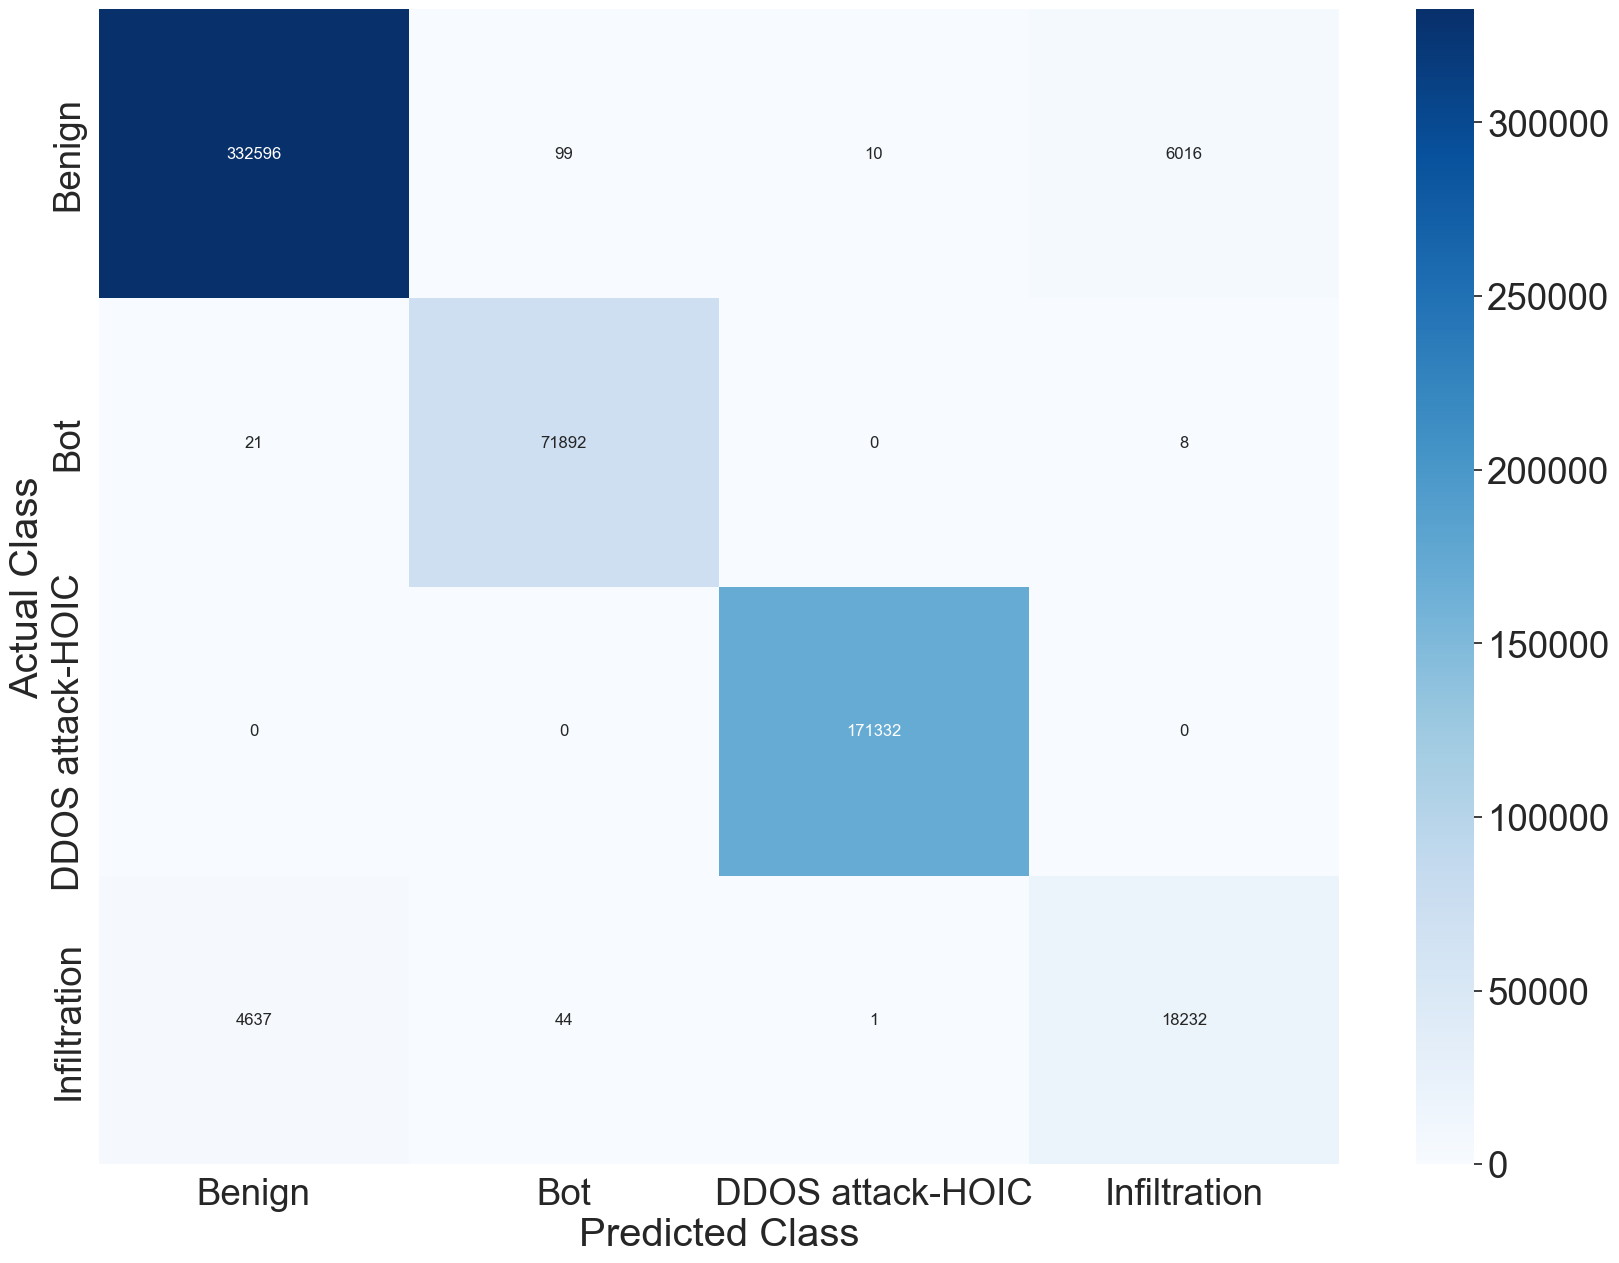

In [47]:
cm_df = pd.DataFrame(confMat)

labels = ['Benign', 'Bot', 'DDOS attack-HOIC', 'Infiltration']

plt.figure(figsize=(20,15))
sn.set(font_scale=2.4)
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 

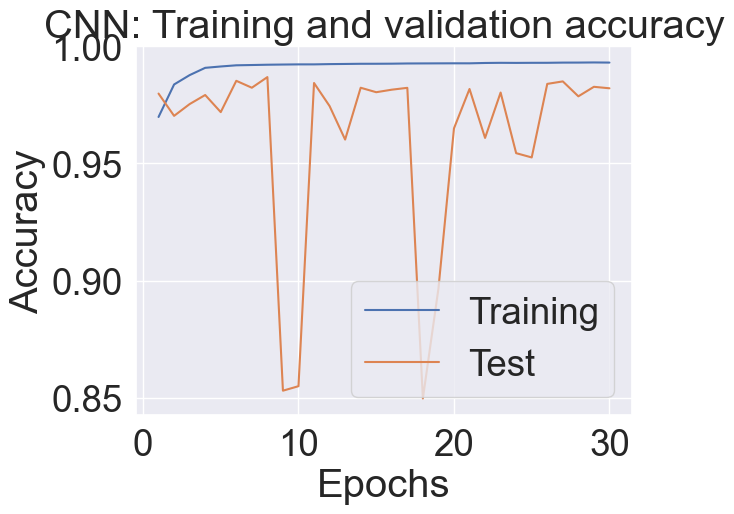

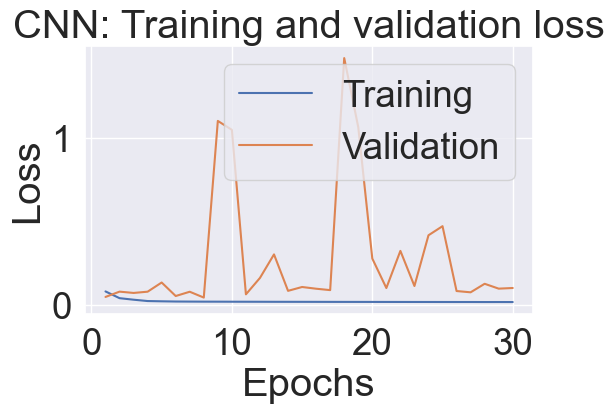

<Figure size 640x480 with 0 Axes>

In [48]:
start_epoch = 1
epochs = range(start_epoch, len(loss_values) + 1)

plt.plot(epochs, acc[start_epoch-1:], label='Training accuracy')
plt.plot(epochs, val_acc[start_epoch-1:], label='Validation accuracy')
plt.title('CNN: Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Test'], loc='lower right')

plt.show()
plt.clf()

plt.plot(epochs, loss_values[start_epoch-1:], label='Training Loss')
plt.plot(epochs, val_loss_values[start_epoch-1:], label='Validation Loss')
plt.title('CNN: Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()
plt.clf()